<a href="https://colab.research.google.com/github/sdhar2020/K-Nearest-Neighbor/blob/master/Predicting_Car_Prices_D1_0_02282020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Car Prices

This exercise is about predicting car prices based on car features. In this exercise kNN alogirhtm is used to build a model to predict prices

# Libraries & Settings




In [1]:
import pandas as pd
import numpy as np
pd.options.display.max_columns = 99
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
RANDOMSEED= 4242
XVAL= 5

# Data Load & Read

This s the car price data set that comes as a standard data set in many python packages including plotly.

In [2]:
gitlnk = 'https://raw.githubusercontent.com/plotly/datasets/master/imports-85.csv'

In [4]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 
        'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv(gitlnk, names=cols, header= 'infer')

In [7]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'bore', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
numeric_cars = cars[continuous_values_cols]

In [8]:
numeric_cars.describe()

,normalized-losses,wheel-base,length,width,height,curb-weight,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,165,206,206,206,206,206,202,202,206,204,204,206,206,202
unique,52,54,76,45,50,172,39,37,33,60,24,30,31,187
top,161,94.50,157.30,63.80,50.80,2385,3.62,3.40,9.00,68,5500,31,25,7609
freq,11,21,15,24,14,4,23,20,46,19,37,28,19,2


The function below converts the numerical fields into float and wherever it faisl to do so replaces with a NaN

In [9]:
def to_num(x):
  try:
    x= float(x)
  except ValueError:
    x= np.NaN
  return(x)

In [10]:
numeric_cars= numeric_cars.applymap(lambda x: to_num(x))

In [11]:
numeric_cars.isnull().sum()

normalized-losses    42
wheel-base            1
length                1
width                 1
height                1
curb-weight           1
bore                  5
stroke                5
compression-rate      1
horsepower            3
peak-rpm              3
city-mpg              1
highway-mpg           1
price                 5
dtype: int64

## Missing Values

In [12]:
# Because `price` is the column we want to predict, let's remove any rows with missing `price` values.
numeric_cars = numeric_cars.dropna(subset=['price'])
numeric_cars.isnull().sum()

normalized-losses    37
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
bore                  4
stroke                4
compression-rate      0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 0
dtype: int64

In [13]:
# Replace missing values in other columns using column means.
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

In [14]:
numeric_cars.isnull().sum()

normalized-losses    0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
bore                 0
stroke               0
compression-rate     0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

# Feature readiness for modeling

In [15]:
# Normalize all columnns to range from 0 to 1 except the target column.
price_col = numeric_cars['price']
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price_col

In [16]:
cat_vars= list(set(cars.columns) - set(continuous_values_cols))

In [17]:
car_cat_cols = cars[cat_vars][1:]

In [18]:
int_cols= ['symboling', 'num-of-cylinders', 'engine-size']

In [19]:
cat_vars = list(set(cat_vars) - set(int_cols))

In [20]:
dummy_df = pd.get_dummies(car_cat_cols[cat_vars])

In [21]:
df= numeric_cars.merge(dummy_df, how='left', left_index=True, right_index=True)

In [22]:
df = df.merge(cars[int_cols], how='left', left_index=True, right_index=True)

In [23]:
df.isnull().sum()[df.isnull().sum()> 0]

Series([], dtype: int64)

In [24]:
df.shape

(201, 70)

70 features including all integer, categorical and numerical variables

# K- Nearest Neighbour test Harness

The function written taks the following input:
- Pandas Dataframe
- List of Features
- Name of target column
- Number of Neighbors to calculate the predicted value
- Randomseed for seeing the KFold Cross Validation
- CV: # of Cros Validation Folds
Takes the dataframe and splits into CV splits fits using CV-1 split  and validats on 1 split randomly split with repitiions.

rsme calculated as a sqrt of sum of mses/CV.
rsses stored as a dictionary for everyvalue of K neighbors and returned as function outputs

In [25]:
def knn_train_test(df, train_cols, target_col, neighbors=[5], seed= RANDOMSEED, CV= XVAL):
  df = df.copy(deep=True)
  X = df[train_cols]
  Y = df[target_col]
  kf= KFold(n_splits=CV, random_state=seed, shuffle=True)
  rmses= {}
  for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors=k)
    mses=[]
    for train_index, test_index in kf.split(X):
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
      knn.fit(X_train, y_train)
      predicted_labels = knn.predict(X_test)
      # Calculate and return RMSE.
      mse = mean_squared_error(y_test, predicted_labels)
      mses.append(mse)
    rmse = np.sqrt(sum(mses)/CV)
    rmses[k]= rmse
  return(rmses)


All Training Columns:

In [26]:
train_cols = df.columns.drop('price')

Running kNN for single variables while changing the K value from 1 to 24 to see what generates the best results

In [27]:
rmse_results = {}
for col in train_cols:
    rmse_val = knn_train_test(df, [col], 'price', [i for i in range(1, 25)])
    rmse_results[col] = rmse_val
# Create a Series object from the dictionary so 
# we can easily view the results, sort, etc

Lowest RSMEs for each st of columns based on the nearest Neighbor

In [28]:
lowest_rsme= {}
for k,v in rmse_results.items():
  lowest_rsme[k]= v[min(v.keys(), key=(lambda k1: v[k1]))]

In [29]:
rmse_results_series = pd.DataFrame.from_dict(lowest_rsme, orient='index', columns=['rsme'])
rmse_results_series.sort_values('rsme', inplace=True, ascending=True)

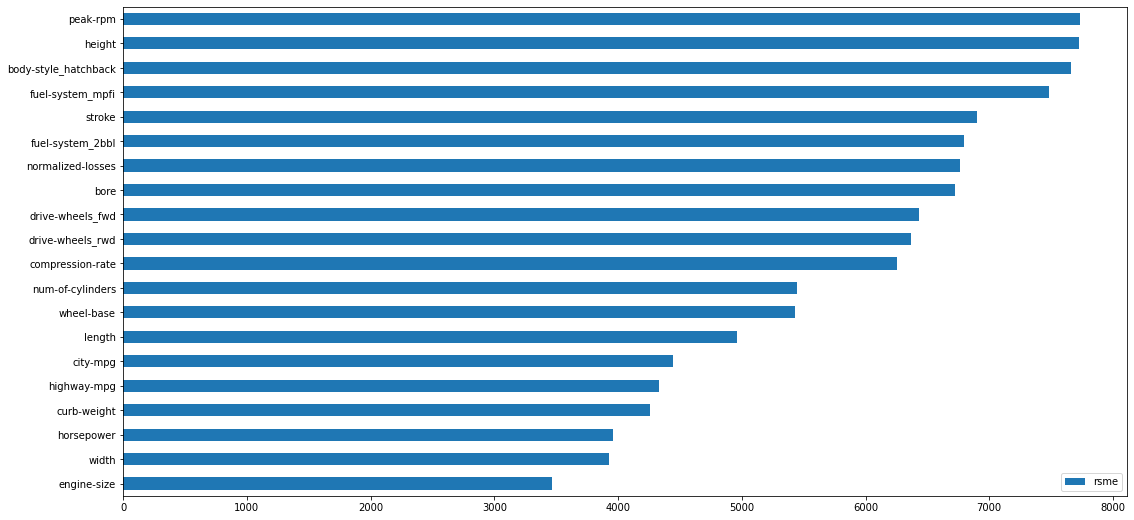

In [30]:
rmse_results_series.head(20).plot(kind='barh', figsize=(18,9))

Shows the top 20 variables with the least RMSEs

# Multivariate kNN

Instead of one feature at a time we now build model with top features based on the single variable. We take the 5,10,15,20,25,50 and all features.

Calculate the RMSES for all settings of neighbours 1 to 24


In [31]:
top_feats= [5,10,15,20,25, 50,70]
rmses = {}
for n in top_feats:
  features = rmse_results_series.head(n).index.tolist()
  rmses[n]= knn_train_test(df, features,'price', [i for i in range(1, 25)])

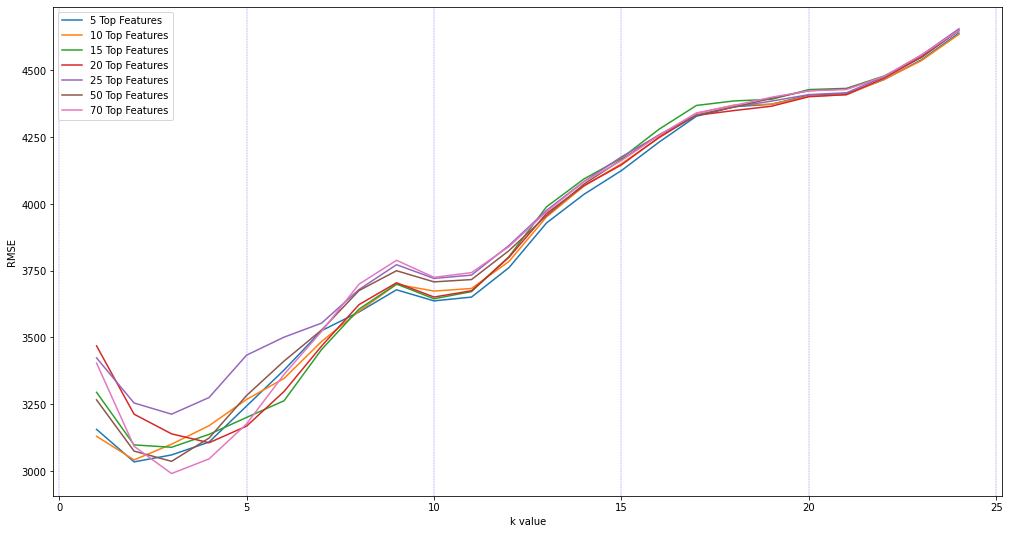

In [32]:
plt.figure(figsize=(17,9))

for k,v in rmses.items():
    x = list(v.keys())
    y = list(v.values())
    
    plt.plot(x,y)
    plt.xlabel('k value')
    plt.ylabel('RMSE')
plt.legend([str(t)+' Top Features' for t in top_feats])   
plt.grid(color='b', ls = '-.', lw = 0.25,axis='x',)

The family of curve show RMSES for the set of features for ech values based on k

In [33]:
rmses
lowest_rsme= {}
for k,v in rmses.items():
  lowest_rsme[k]= {min(v.keys(), key=(lambda k1: v[k1])), v[min(v.keys(), key=(lambda k1: v[k1]))]}

In [34]:
lowest_rsme

{5: {2, 3034.120821136841},
 10: {2, 3041.4617179220527},
 15: {3, 3088.794746758293},
 20: {4, 3105.777211852878},
 25: {3, 3212.754998239476},
 50: {3, 3036.103835175516},
 70: {3, 2990.369833013607}}

We shall choose top 5 features with K=2 for our final model

In [35]:
train_cols= rmse_results_series.head(5).index.tolist()
X = df[train_cols]
y = df['price']
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(X, y)
predicted_labels = knn.predict(X)



Text(0.5, 1.0, 'y=0.970301x+330.150045')

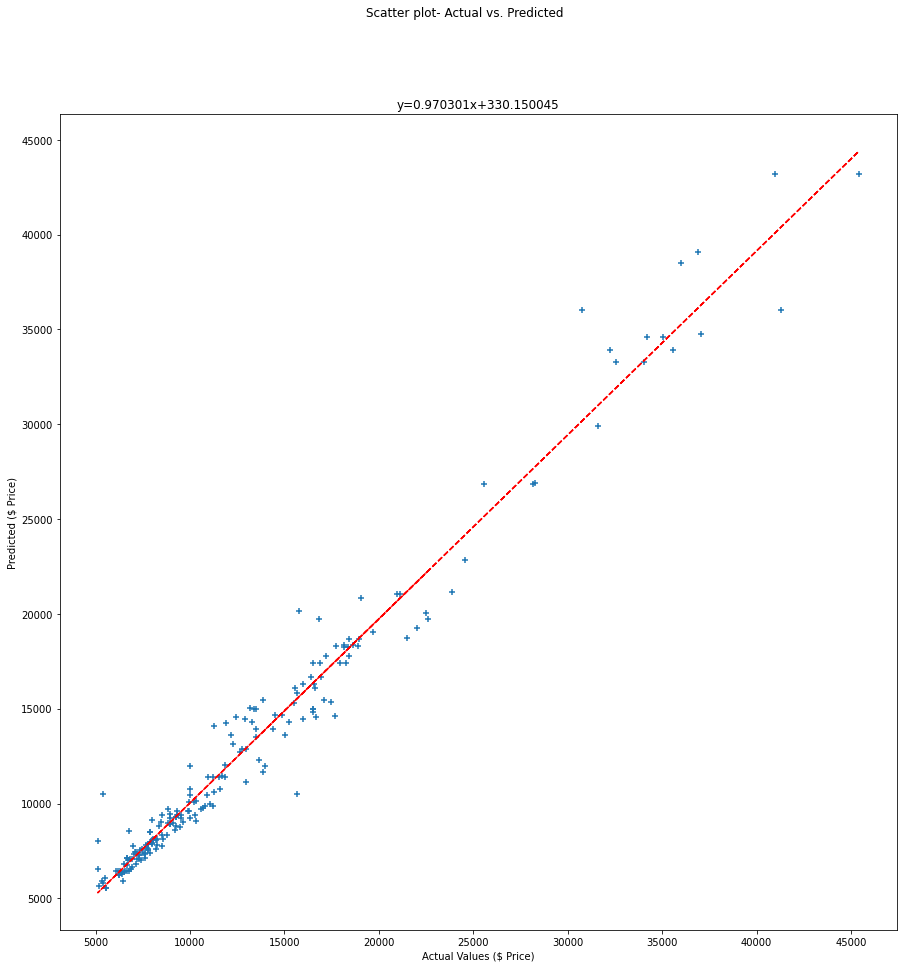

In [36]:
plt.figure(figsize=(15,15))
plt.suptitle('Scatter plot- Actual vs. Predicted')
plt.xlabel('Actual Values ($ Price)')
plt.ylabel('Predicted ($ Price)')
plt.scatter(y.values,predicted_labels, marker= '+')

z = np.polyfit(y.values, predicted_labels, 1)
p = np.poly1d(z)
plt.plot(y.values,p(y.values),"r--")
plt.title("y=%.6fx+%.6f"%(z[0],z[1]))


The actual values vs. predicted value lines up nicely around a 45 degree line. There is a spread at the higher values which can perhaps be taken care of when using a higher order model.

But models that are parsimonious usually behave and generalize well in longer term implementations